In [1]:
from collections import defaultdict
import math
import numpy as np
from numpy import ma
import datetime, time
from datetime import datetime
import netCDF4
from netCDF4 import Dataset, num2date
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

import pickle
import halem
import datetime, time
import numpy as np
timeQ = time

"disable functions below if cartopy is unavailable"
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import halem
import halem.Mesh_maker as Mesh_maker
import halem.Flow_class as Flow_class
import os

import utide
from pandas import DataFrame

from pandas import date_range
from IPython.display import clear_output

def Tidal_analysis(time_orig, time, WD_raw, u_raw, v_raw, Rayleigh_min):
    coef_WD = utide.solve(time_orig, WD_raw,
                         lat=53,
                         nodal=False,
                         trend=False,
                         method='ols',
                         conf_int='linear',
                         Rayleigh_min=Rayleigh_min,)

    WD_predict = utide.reconstruct(time, coef_WD)


    coef_u = utide.solve(time_orig, u_raw,
                         lat=53,
                         nodal=False,
                         trend=False,
                         method='ols',
                         conf_int='linear',
                         Rayleigh_min=Rayleigh_min,)

    u_predict = utide.reconstruct(time, coef_u)

    coef_v = utide.solve(time_orig, v_raw,
                         lat=53,
                         nodal=False,
                         trend=False,
                         method='ols',
                         conf_int='linear',
                         Rayleigh_min=Rayleigh_min,)

    v_predict = utide.reconstruct(time, coef_v)
    
    
    clear_output()
    return WD_predict, u_predict, v_predict

In [2]:
nodes = np.loadtxt('D:/Use_case_Schouwen/tidal_an/nodes.csv')
t = np.loadtxt('D:/Use_case_Schouwen/tidal_an/t.csv')
WD = np.loadtxt('D:/Use_case_Schouwen/tidal_an/d.csv')
u = np.loadtxt('D:/Use_case_Schouwen/tidal_an/u.csv')
v = np.loadtxt('D:/Use_case_Schouwen/tidal_an/v.csv')
add_nodes = np.loadtxt('additional_nodes.csv')[:,::-1]

add_u = griddata(nodes, np.transpose(u), (add_nodes), method='linear')
add_v = griddata(nodes, np.transpose(v), (add_nodes), method='linear')
add_WD = griddata(nodes, np.transpose(WD), (add_nodes), method='linear')

add_u = np.transpose(add_u)
add_v = np.transpose(add_v)
add_WD = np.transpose(add_WD)

u = np.concatenate((u, add_u), axis = 1)
v = np.concatenate((v, add_v), axis = 1)
WD = np.concatenate((WD, add_WD), axis = 1)
nodes = np.concatenate((nodes, add_nodes))

In [3]:
a = 47
b = 361

time_orig = (t)/60/60/24
time = time_orig[::6][a:(a+b)]

time_stamp = []
for T in time:
    time_stamp.append(datetime.datetime.fromtimestamp((T)*60*60*24))
time_stamp = np.array(time_stamp)

time_stamp_orig = []
for T in time_orig:
    time_stamp_orig.append(datetime.datetime.fromtimestamp(T*60*60*24))
    
time_stamp_orig = np.array(time_stamp_orig)

In [4]:
node = 2500
Rayleigh_min = 2.3

WD_raw = WD[:,node]
u_raw = u[:,node]
v_raw = v[:,node]

In [5]:
start_time = timeQ.time()

WD_predict, u_predict, v_predict = Tidal_analysis(time_orig, time, WD_raw, u_raw, v_raw, Rayleigh_min)

stop_time = timeQ.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

the computational time is: 0.3 sec


In [6]:
coef_WD = utide.solve(time_orig, WD_raw,
                     lat=53,
                     nodal=False,
                     trend=False,
                     method='ols',
                     conf_int='linear',
                     Rayleigh_min=Rayleigh_min,)
coef_u = utide.solve(time_orig, u_raw,
                     lat=53,
                     nodal=False,
                     trend=False,
                     method='ols',
                     conf_int='linear',
                     Rayleigh_min=Rayleigh_min,)
coef_v = utide.solve(time_orig, v_raw,
                     lat=53,
                     nodal=False,
                     trend=False,
                     method='ols',
                     conf_int='linear',
                     Rayleigh_min=Rayleigh_min,)
clear_output()


comp = coef_WD['name']
ampl = coef_WD['A']
phase = coef_WD['g']
ddf = [ampl,phase]
ddf = np.transpose(np.array(ddf))
df = DataFrame(ddf, index = comp, columns=['Amplitude h', 'Phase h'])

phase = coef_u['g']
ampl = coef_u['A']
df['Amplitude u'] = ampl
df['Phase u'] = phase

phase = coef_v['g']
ampl = coef_v['A']
df['Amplitude v'] = ampl
df['Phase v'] = phase
df = df.round(2)

df.to_csv('tidal_constituents.csv')

,Amplitude h,Phase h,Amplitude u,Phase u,Amplitude v,Phase v
M2,1.35,86.21,0.36,109.98,0.57,43.35
S2,0.30,19.04,0.08,41.53,0.13,340.16
M4,0.14,173.52,0.03,125.64,0.04,198.10
M6,0.10,155.61,0.03,103.01,0.03,233.55
O1,0.09,250.04,0.02,49.02,0.02,127.77
K1,0.08,298.02,0.01,63.94,0.02,155.61
MS4,0.08,112.31,0.01,190.12,0.02,160.57
2MS6,0.08,89.23,0.01,145.95,0.01,206.99
MSF,0.05,270.89,0.01,228.70,0.01,167.12
M8,0.03,219.37,0.00,69.92,0.01,209.96


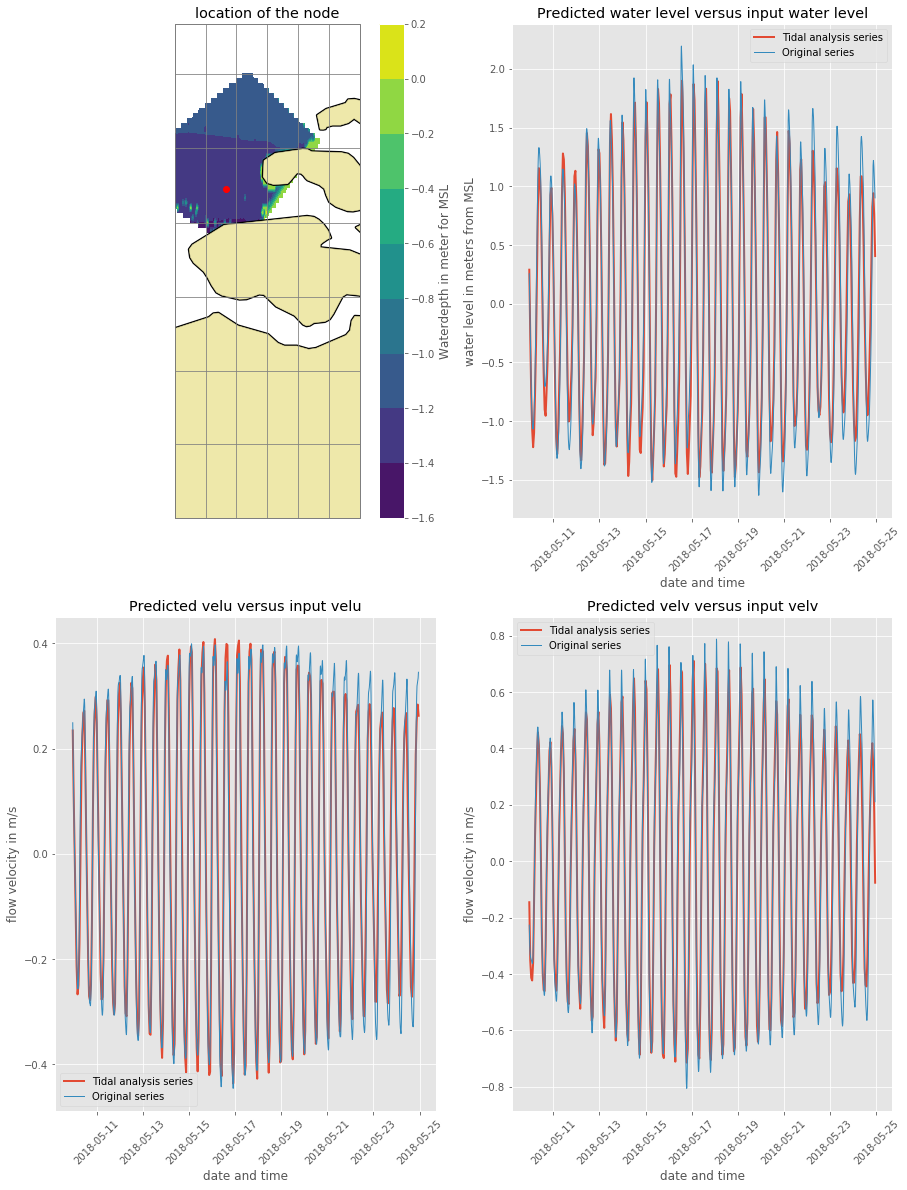

In [7]:
x_r = np.arange(3.4,4, 0.001)
y_r = np.arange(51,52, 0.01)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = griddata((nodes[:,1], nodes[:,0]), WD[0], (x_r, y_r), method= 'linear')

fig = plt.figure(figsize = (15,20))

display(df)

ax = plt.subplot(2,2,1, projection=ccrs.Mercator())
ax.coastlines(resolution='10m', color='black', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.set_extent([3.4,4, 51,52], crs=ccrs.PlateCarree())

plt.contourf(x_r,y_r,WD_r, transform=ccrs.PlateCarree())
cbar = plt.colorbar()
cbar.set_label('Waterdepth in meter for MSL')
plt.plot(nodes[node,1], nodes[node,0], 'ro', transform=ccrs.PlateCarree(), zorder = 1)

plt.title('location of the node')

ax3 = plt.subplot(2,2,2)
plt.plot(time_stamp[:b], WD_predict['h'][:b], label = 'Tidal analysis series', linewidth = 2)
plt.plot(time_stamp_orig[np.argwhere(time[0] == time_orig)[0,0]: np.argwhere(time[-1] == time_orig)[0,0]],WD_raw[np.argwhere(time[0] == time_orig)[0,0]: np.argwhere(time[-1] == time_orig)[0,0]], label = 'Original series', linewidth = 1)
plt.legend(loc = 'best')
plt.title('Predicted water level versus input water level')
plt.xlabel('date and time')
plt.ylabel('water level in meters from MSL')
plt.setp(ax3.get_xticklabels(), rotation=45)


ax2 = plt.subplot(2,2,3)
plt.plot(time_stamp[:b], u_predict['h'][:b], label = 'Tidal analysis series', linewidth = 2)
plt.plot(time_stamp_orig[np.argwhere(time[0] == time_orig)[0,0]: np.argwhere(time[-1] == time_orig)[0,0]],u_raw[np.argwhere(time[0] == time_orig)[0,0]: np.argwhere(time[-1] == time_orig)[0,0]], label = 'Original series', linewidth = 1)
plt.legend(loc = 'best')
plt.title('Predicted velu versus input velu')
plt.xlabel('date and time')
plt.ylabel('flow velocity in m/s')
plt.setp(ax2.get_xticklabels(), rotation=45)


ax1 = plt.subplot(2,2,4)
plt.plot(time_stamp[:b], v_predict['h'][:b], label = 'Tidal analysis series', linewidth = 2)
plt.plot(time_stamp_orig[np.argwhere(time[0] == time_orig)[0,0]: np.argwhere(time[-1] == time_orig)[0,0]],v_raw[np.argwhere(time[0] == time_orig)[0,0]: np.argwhere(time[-1] == time_orig)[0,0]], label = 'Original series', linewidth = 1)
plt.legend(loc = 'best')
plt.title('Predicted velv versus input velv')
plt.xlabel('date and time')
plt.ylabel('flow velocity in m/s')
plt.setp(ax1.get_xticklabels(), rotation=45)

plt.savefig('Tidal_analysis_output.jpg')
plt.show()

In [8]:
x_r = np.arange(3.2,3.8, 0.001)
y_r = np.arange(51,52, 0.01)
y_r, x_r = np.meshgrid(y_r,x_r)

bat = np.loadtxt('D:/Use_case_Schouwen/baty_WGS.csv')[:,2]
nodes_bat = np.loadtxt('D:/Use_case_Schouwen/baty_WGS.csv')[:,:2]
bath = griddata(nodes_bat, bat, (x_r, y_r), method= 'linear')

WD_r2 = griddata((nodes[:,1], nodes[:,0]), WD[46], (x_r, y_r), method= 'linear')
WD_r2 = WD_r2 - bath                      # WD in LAT bath in NAP ??????????

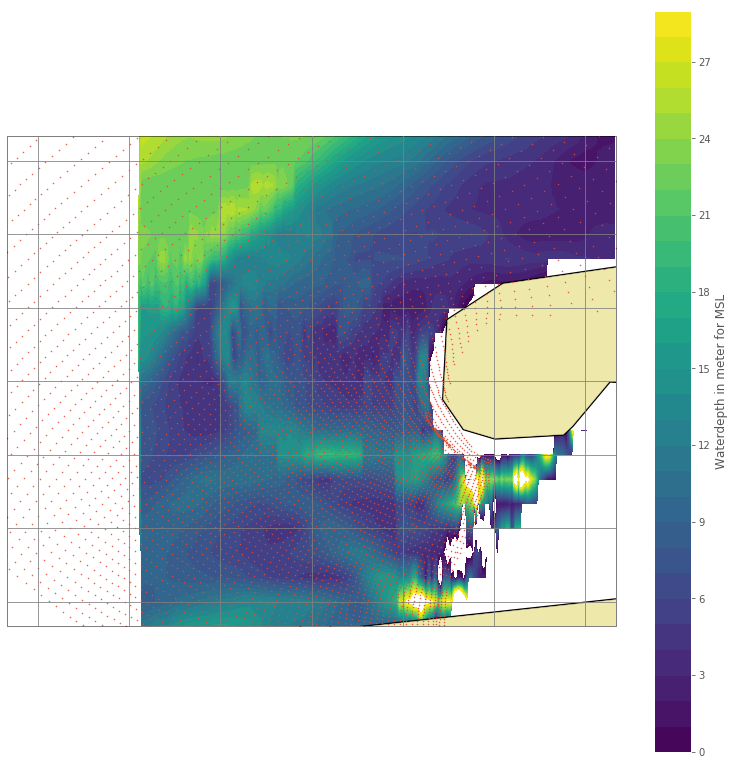

In [9]:
fig = plt.figure(figsize = (30,30))
ax = plt.subplot(2,2,1, projection=ccrs.Mercator())
ax.coastlines(resolution='10m', color='black', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))

cval = np.arange(0,30)
plt.contourf(x_r,y_r,WD_r2,cval, transform=ccrs.PlateCarree())
cbar = plt.colorbar()
cbar.set_label('Waterdepth in meter for MSL')
plt.plot(nodes[:,1], nodes[:,0], '.', markersize = 1, transform=ccrs.PlateCarree())
ax.set_extent([3.4,3.8,51.6,51.8], crs=ccrs.PlateCarree())


plt.show()

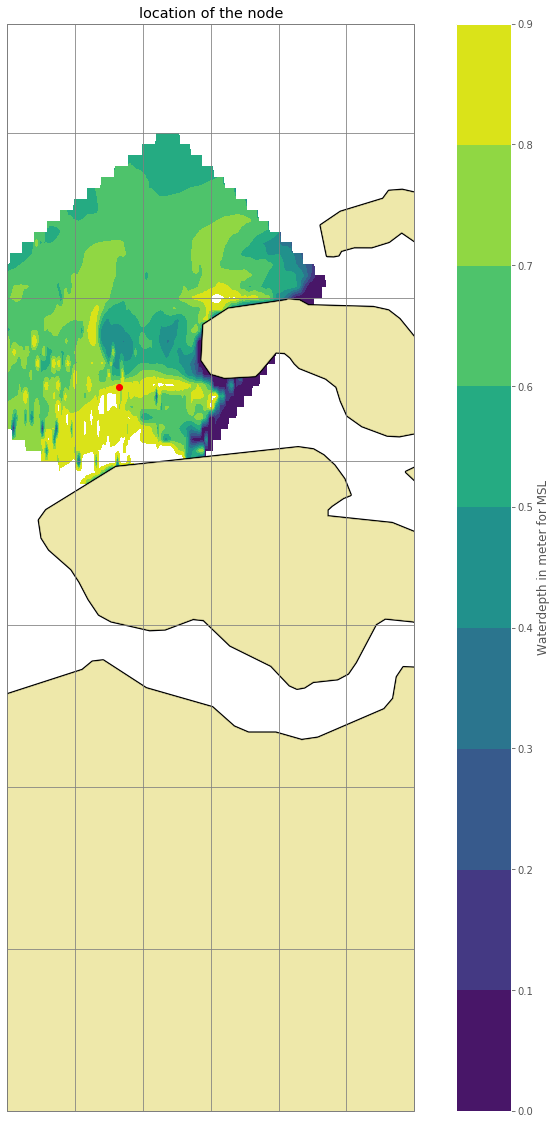

In [10]:
x_r = np.arange(3.4,4, 0.001)
y_r = np.arange(51,52, 0.01)
y_r, x_r = np.meshgrid(y_r,x_r)

UV = (u**2 + v**2) ** 0.5

K = np.argwhere(UV[:,node] == UV[:,node].max())[0,0]

WD_r = griddata((nodes[:,1], nodes[:,0]), UV[K], (x_r, y_r), method= 'linear')

fig = plt.figure(figsize = (15,20))

ax = plt.subplot(1,1,1, projection=ccrs.Mercator())
ax.coastlines(resolution='10m', color='black', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='palegoldenrod'))
ax.set_extent([3.4,4, 51,52], crs=ccrs.PlateCarree())

cval = np.arange(0,1,0.1)
plt.contourf(x_r,y_r,WD_r,cval, transform=ccrs.PlateCarree())
cbar = plt.colorbar()
cbar.set_label('Waterdepth in meter for MSL')
plt.plot(nodes[node,1], nodes[node,0], 'ro', transform=ccrs.PlateCarree(), zorder = 1)

plt.title('location of the node')

plt.show()

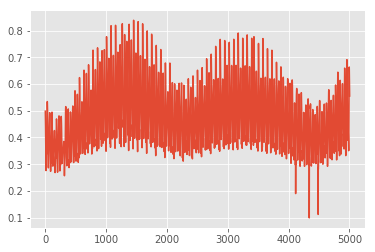

In [11]:
plt.plot(UV[:,node])